In [20]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime

# Path to the pcap file
pcap_file = "ofh_100Mhz_30kHz_tdd_7d2u.pcap"

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.tpid == 0xaefe:  # Check if it contains an eCPRI frame
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                    else:
                        iq_data_count += 1
                    oran_header = ofhheader.read(buf, 22)
                    # Update flow arrival times
             
                    update_flow_arrival_times(timestamp, ecpri_header, len(buf))

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        # print(time_diff)
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate'] / 1e9):.3f} Gbps, ArrivalRate = {(arrival_rate['ArrivalRate']):.2f} Pkts/s")


Flow C-Plane || BitRate = 0.001 Gbps, ArrivalRate = 1999.98 Pkts/s
Flow U-Plane || BitRate = 1.303 Gbps, ArrivalRate = 21199.93 Pkts/s


# Version DPKT - # pkts in slot

### 1 antenna - BW_FR1 =  100 Mhz SCS = 30 KHz

In [14]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "test_7d2u.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = (1/(2**mu))

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.tpid == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


Flow C-Plane || BitRate = 1.02 Mbps
Flow U-Plane || BitRate = 1302.52 Mbps
Avg C-pkts/s: 1.00 || Avg U-pkts/s: 10.60
Avg Rate C-pkts: 1.02 Mbps || Avg Rate U-pkts: 1302.51 Mbps
U-pkts: 1118801 || 1118801
C-pkts: 105547 || 105547
Slots: 105547.86968231201 || 105549


In [18]:
# Print DataFrame and other statistics
print("DataFrame Structure and Data:")
print(df_packets.head())
df_packets.to_csv('test_7d2u.csv', sep=' ', float_format='%.2f', index=False)

DataFrame Structure and Data:
     init_time     end_time U-pkts C-pkts
0  6638.689995  6639.189995      9      2
1  6639.189995  6639.689995     14      1
2  6639.689995  6640.189995     14      1
3  6640.189995  6640.689995     14      1
4  6640.689995  6641.189995     13      0


### 1 antenna - BW_FR1 =  20 Mhz SCS = 30 KHz

In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru20.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = (1/(2**mu))

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


In [ ]:

print(flow_arrival_times)
print(time_diff/slot_window)
# print(10540.015935897827 - 2839.7059440612793)
print(len(df_packets))


# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
print(df_packets.head())
print(df_packets.tail())
print(counter)

## 2 antenna - BW-FR1 = 20 MHz SCS = 30 KHz

In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "ru_20_30.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = (1/(2**mu))

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd






In [ ]:
df_packets.to_csv('ru_20_30.txt', sep='\t', index=False)


## 4 antenna - BW-FR1 = 20 MHz SCS = 30 KHz

In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "ru_20_30_4.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = (1/(2**mu))

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


In [ ]:
df_packets.to_csv('ru_20_30_4.txt', sep='\t', index=False)


# 1 antenna 20 MHz 20KHz

In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru20_tdd10_1.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru100_tdd10.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


In [ ]:
df_packets.to_csv('gnB100_tdd10.txt', sep='\t', index=False)


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru20_tdd6_1.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


Flow C-Plane || BitRate = 0.92 Mbps
Flow U-Plane || BitRate = 215.37 Mbps
Avg C-pkts/s: 0.90 || Avg U-pkts/s: 9.19
Avg Rate C-pkts: 0.92 Mbps || Avg Rate U-pkts: 215.36 Mbps
U-pkts: 261168 || 261168
C-pkts: 25552 || 25552
Slots: 28405.049800872803 || 28407


In [ ]:
df_packets.to_csv('gnB_ru20_tdd6_1.txt', sep='\t', index=False)


0         3555.501938
1         3556.001938
2         3556.501938
3         3557.001938
4         3557.501938
             ...     
28402    17756.501938
28403    17757.001938
28404    17757.501938
28405    17758.001938
28406    17758.501938
Name: init_time, Length: 28407, dtype: float64


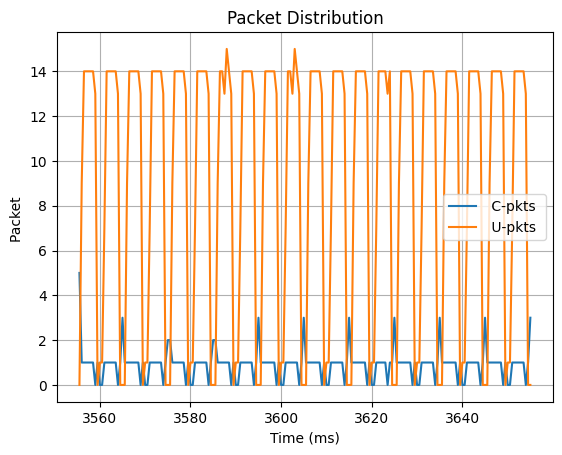

In [ ]:

import matplotlib.pyplot as plt
# Calculate the cumulative sum of packets for each type
# Group two slots from df_packets


df_packets['Cumulative_C-pkts'] = df_packets['C-pkts'] 
df_packets['Cumulative_U-pkts'] = df_packets['U-pkts'] 

# Calculate the total number of packets
total_packets = df_packets['C-pkts'].sum() + df_packets['U-pkts'].sum()

# Calculate the cumulative sum of packets divided by the total
df_packets['Cumulative_C-pkts_Percent'] = df_packets['Cumulative_C-pkts'] 
df_packets['Cumulative_U-pkts_Percent'] = df_packets['Cumulative_U-pkts'] 


# Plot the distribution of cumulative packet counts
plt.plot(df_packets['init_time'].values[0:200], df_packets['Cumulative_C-pkts_Percent'].values[0:200], label=' C-pkts ')
plt.plot(df_packets['init_time'].values[0:200], df_packets['Cumulative_U-pkts_Percent'].values[0:200], label=' U-pkts')

# Customize the plot
plt.xlabel('Time (ms)')
plt.ylabel('Packet ')
plt.title('Packet Distribution')
plt.legend()

# Show the plot
plt.grid()
plt.show()


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru20_tdd7_1.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


Flow C-Plane || BitRate = 1.02 Mbps
Flow U-Plane || BitRate = 248.27 Mbps
Avg C-pkts/s: 1.00 || Avg U-pkts/s: 10.60
Avg Rate C-pkts: 1.02 Mbps || Avg Rate U-pkts: 248.26 Mbps
U-pkts: 288346 || 288346
C-pkts: 27203 || 27203
Slots: 27205.222129821777 || 27206


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru100_tdd6_1.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


ModuleNotFoundError: No module named 'packet'

In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru100_tdd7_1.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")


Flow C-Plane || BitRate = 1.01 Mbps
Flow U-Plane || BitRate = 1285.07 Mbps
Avg C-pkts/s: 0.99 || Avg U-pkts/s: 10.46
Avg Rate C-pkts: 1.01 Mbps || Avg Rate U-pkts: 1285.03 Mbps
U-pkts: 311710 || 311710
C-pkts: 29416 || 29416
Slots: 29806.212425231934 || 29807


In [ ]:
df_packets.to_csv('gnB_ru20_tdd6_1.txt', sep='\t', index=False)


In [ ]:
from pylibpcap.pcap import rpcap
from packet import *
import dpkt
import time
from datetime import datetime
import pandas as pd

# Initialize an empty DataFrame with the required columns
columns = ['init_time', 'end_time', 'U-pkts', 'C-pkts']
df_packets = pd.DataFrame(columns=columns)
# Path to the pcap file
pcap_file = "gnB_ru100_tdd7_4.pcap"

# Slot duration in milliseconds
mu = 1
counter = 1

# Dictionary to store arrival times of different flows
flow_arrival_times = {}
arrival_rate_map = {}
# Variables to count the arrival of different eCPRI message types
iq_data_count = 0
real_time_control_count = 0
slot_window = 1/(2**mu)

init_time = 0
end_time = 0

# Function to process packets
def process_packets(pcap_file):
    global iq_data_count, real_time_control_count, init_time, end_time, df_packets, init_cap, timestamp
    first = True
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap: 
            if first:
                init_cap = timestamp
                first = False
            # print(f"{timestamp} {init_cap}")
            timestamp = timestamp - init_cap
            timestamp = timestamp*1e3
            # print(timestamp)
            # print(f"{timestamp}")
            ethh = ethheader.read(buf, 0)
            if ethh.ethtype == 0x8100:  # Check if it's a VLAN tagged frame
                # Extract VLAN tag
                vlan_tag = vlanheader.read(buf, 14)
                if vlan_tag.type == 0xaefe:  # Check if it contains an eCPRI packet (example)
                    # Extract eCPRI payload
                    ecpri_header = ecpriheader.read(buf, 18)
                    if ecpri_header.payload_type == 0x02:
                        real_time_control_count += 1
                        # print(f"{init_time} {end_time} {timestamp}")
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "C-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                    else:
                        iq_data_count += 1
                        init_time, end_time, df_packets = calculate_packets_per_slot(df_packets, init_time, end_time, timestamp, "U-pkts")
                        # Update flow arrival times
                        update_flow_arrival_times(timestamp, ecpri_header, len(buf))
                else:
                    print("Not eCPRI")       
            # if counter==4:
            #     break
                    
                   

# Function to update flow arrival times
def update_flow_arrival_times(timestamp, ecpri_header, length):
    flow_key = ecpri_header.payload_type  # Assuming cpri_id uniquely identifies flows
    if flow_key in flow_arrival_times:
        flow_arrival_times[flow_key]['last'] = timestamp
    else:
        flow_arrival_times[flow_key] = {'first': timestamp, 'last': timestamp, 'size': length}

# Calculate arrival rate for each flow
def calculate_flow_arrival_rate():
    global time_diff
    for flow_key, timestamps in flow_arrival_times.items():
        first_timestamp = timestamps['first']
        last_timestamp = timestamps['last']
        time_diff = last_timestamp - first_timestamp
        if time_diff != 0:
            if flow_key == 0x00:
                arrival_rate = iq_data_count * (timestamps['size']) * 8 / time_diff
            else:
                arrival_rate = real_time_control_count * (timestamps['size']) * 8 / time_diff
            arrival_rate_map[flow_key] = {'Rate': arrival_rate, 'ArrivalRate': arrival_rate / (8 * timestamps['size'])}

# Function to calculate packets per slot
def calculate_packets_per_slot(df_packets, init_time, end_time, current_time, Plane_tag):
    global counter 
    if init_time in df_packets['init_time'].values and current_time <= end_time:
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] += 1
    else:
        # Update the init_time and end_time
        if(init_time == end_time):    
            init_time = current_time
        else:
            init_time = end_time
        end_time = init_time + slot_window
        # Create a DataFrame with the new row
        new_row = pd.DataFrame({'init_time': [init_time], 'end_time': [end_time], 'U-pkts': [0], 'C-pkts': [0]})
        # Concatenate the new row to the original DataFrame and assign it back to df_packets
        df_packets = pd.concat([df_packets, new_row], ignore_index=True)
        # Update the values in the new row
        df_packets.loc[df_packets['init_time'] == init_time, Plane_tag] = 1
        counter+=1
       
    return init_time, end_time, df_packets



# Process packets from the pcap file
process_packets(pcap_file)

# Calculate arrival rate for each flow
calculate_flow_arrival_rate()


# Display counts of each eCPRI message type
for flow_key, arrival_rate in arrival_rate_map.items():
    if flow_key == 2:
        flow_name = "C-Plane"
    else:
        flow_name = "U-Plane"
    print(f"Flow {flow_name} || BitRate = {(arrival_rate['Rate']*1e-3):.2f} Mbps")

# Print DataFrame and other statistics
# print("DataFrame Structure and Data:")
# print(df_packets.head())

# Print averages, sums, and other statistics
print(f"Avg C-pkts/s: {df_packets['C-pkts'].mean():.2f} || Avg U-pkts/s: {df_packets['U-pkts'].mean():.2f}")
print(f"Avg Rate C-pkts: {(((df_packets['C-pkts'].mean()*8*64)/slot_window*1e-3)):.2f} Mbps || Avg Rate U-pkts: {(((df_packets['U-pkts'].mean()*8*flow_arrival_times[0]['size'])/slot_window*1e-3)):.2f} Mbps")
print(f"U-pkts: {df_packets['U-pkts'].sum()} || {iq_data_count}")
print(f"C-pkts: {df_packets['C-pkts'].sum()} || {real_time_control_count}")
print(f"Slots: {time_diff/slot_window} || {len(df_packets)}")
